#**Importing Libraries**

In [ ]:
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
to_tensor = transforms.ToTensor()
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.auto import tqdm
import itertools
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch import nn, optim
import zipfile
from google.colab import drive


# **Mounting Dataset**

In [ ]:
drive.mount('/content/drive/')
traindata_path = "/content/drive/MyDrive/Ai_proj/seg_train"
valdata_path = "/content/drive/MyDrive/Ai_proj/seg_test"
testset_path = "/content/drive/MyDrive/Ai_proj/seg_pred"


Mounted at /content/drive/


# **Image Dataset Loading with Data Augmentation and Transformation**

In [ ]:
def load_dataset(training_path, validation_path):
    # Define transformations for training data (including augmentation) and validation data.
    training_transformations = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Resize([50, 50], antialias=True),
    ])

    validation_transformations = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize([50, 50], antialias=True)
    ])

    # Load training and validation datasets with respective transformations.
    dataset_train = datasets.ImageFolder(training_path, transform=training_transformations)
    dataset_val = datasets.ImageFolder(validation_path, transform=validation_transformations)

    # Create data loaders for training and validation datasets.
    loader_train = DataLoader(dataset_train, batch_size=64, num_workers=4, shuffle=True, drop_last=True)
    loader_val = DataLoader(dataset_val, batch_size=500, drop_last=False)

    return loader_train, loader_val


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# **Custom CNN Architecture with Variable Blocks and Filters**

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, block_count, filter_counts, filter_size=3, activation_fn=nn.ReLU(), sample_down='maxpool', dropout_rate=0.5):
        super(CustomCNN, self).__init__()

        # Initialize a list to store convolutional blocks
        self.conv_blocks = nn.ModuleList()

        # Ensure filter_counts is a list with the same length as block_count or convert to a list
        if isinstance(filter_counts, list):
            assert len(filter_counts) == block_count
        else:
            filter_counts = [filter_counts] * block_count

        # Starting with 3 input channels
        filter_counts = [3] + filter_counts

        # Create convolutional blocks based on the specified parameters
        for index in range(block_count):
            conv_block = self.create_block(filter_counts[index], filter_counts[index + 1], filter_size, activation_fn, sample_down, dropout_rate)
            self.conv_blocks.append(conv_block)

        # Global average pooling and final linear layer for classification
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(filter_counts[-1], 6)  # 6 output classes

    def create_block(self, input_filters, output_filters, filter_size, activation_fn, sample_down, dropout_rate):
        # Initialize layers for a convolutional block
        block_layers = []

        # Set convolution stride based on the specified sample_down method
        conv_stride = 2 if sample_down == "stride" else 1

        # Batch normalization, convolution, dropout, and activation layers
        block_layers.append(nn.BatchNorm2d(input_filters))
        block_layers.append(nn.Conv2d(in_channels=input_filters, out_channels=output_filters, kernel_size=filter_size, padding=1, stride=conv_stride))
        block_layers.append(nn.Dropout2d(p=dropout_rate))
        block_layers.append(activation_fn)

        # Add max pooling layer if sample_down is 'maxpool'
        if sample_down == 'maxpool':
            block_layers.append(nn.MaxPool2d(2, 2))

        return nn.Sequential(*block_layers)

    def forward(self, input_tensor):
        # Pass input through each convolutional block
        for block in self.conv_blocks:
            input_tensor = block(input_tensor)

        # Global average pooling, flatten, and final classification
        input_tensor = self.avg_pool(input_tensor)
        input_tensor = input_tensor.view(input_tensor.size(0), -1)
        input_tensor = self.classifier(input_tensor)

        return input_tensor

# **Residual CNN with Dynamic Block Number and Filter Size**

In [ ]:
class ResidualCNN(nn.Module):
    def __init__(self, block_num, filter_num, kernel_sz=3, activation_fn=nn.ReLU(), downsample_method='maxpool', dropout_rate=0.5, padding_size=1):
        super(ResidualCNN, self).__init__()

        # Initialize a list to store residual blocks
        self.res_blocks = nn.ModuleList()

        # First convolutional layer with a kernel size of 1
        self.first_layer = nn.Conv2d(3, filter_num, kernel_size=1)
        self.first_activation = activation_fn

        # Create residual blocks based on the specified parameters
        for i in range(block_num):
            res_block = self.create_res_block(filter_num, filter_num, kernel_sz, activation_fn, downsample_method, dropout_rate, padding_size)
            self.res_blocks.append(res_block)

        # Final max pooling, global average pooling, and linear layer for classification
        self.final_maxpool = nn.MaxPool2d(2, 2)
        self.final_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.final_classifier = nn.Linear(filter_num, 6)  # 6 output classes

    def create_res_block(self, in_filter, out_filter, kernel_sz, activation_fn, downsample_method, dropout_rate, padding_size):
        # Initialize layers for a residual block
        res_layers = []

        # Batch normalization, convolution, dropout, and activation layers
        res_layers.append(nn.BatchNorm2d(in_filter))
        res_layers.append(nn.Conv2d(in_channels=in_filter, out_channels=out_filter, kernel_size=kernel_sz, padding=padding_size, stride=1))
        res_layers.append(nn.Dropout2d(p=dropout_rate))
        res_layers.append(activation_fn)

        return nn.Sequential(*res_layers)

    def forward(self, input_tensor):
        # Pass input through the first layer and activation
        input_tensor = self.first_layer(input_tensor)
        input_tensor = self.first_activation(input_tensor)

        # Pass input through each residual block, adding the original input
        for res_block in self.res_blocks:
            y = res_block(input_tensor)
            input_tensor = input_tensor + y
            input_tensor = self.final_maxpool(input_tensor)

        # Global average pooling, flatten, and final classification
        input_tensor = self.final_avg_pool(input_tensor)
        input_tensor = input_tensor.view(input_tensor.size(0), -1)
        input_tensor = self.final_classifier(input_tensor)

        return input_tensor


# ****Grid Search Parameters Configuration****

In [ ]:
def grid_search_parameters():
    # Define parameter values for grid search
    block_values = [3]
    channel_values = [64, 128, 256]
    kernelsize_val = [3]
    activation_functions = [nn.ReLU(), nn.Sigmoid()]
    downsampling_methods = ['maxpool', 'stride']
    dropout_probabilities = [0.3, 0.5]

    # Generate all combinations of parameter values using itertools.product
    return itertools.product(block_values, channel_values, kernelsize_val, activation_functions, downsampling_methods, dropout_probabilities)

# **Model Training and Validation Loop**

In [ ]:
def train_and_validate_model(cnn_model, loader_training, loader_validation, loss_criterion, opt, epoch_count, device_type):
    # Training and validation loop over multiple epochs
    for epoch in range(epoch_count):
        # Set the model to training mode
        cnn_model.train()
        losses_train = []
        correct_preds = 0
        total_preds = 0

        # Training phase
        for inputs, labels in loader_training:
            inputs, labels = inputs.to(device_type), labels.to(device_type)

            # Zero the gradients, forward pass, backward pass, and optimization step
            opt.zero_grad()
            outputs = cnn_model(inputs)
            loss = loss_criterion(outputs, labels)
            loss.backward()
            opt.step()

            # Track training losses and accuracy
            losses_train.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total_preds += labels.size(0)
            correct_preds += (predicted == labels).sum().item()

        # Calculate average training loss and accuracy for the epoch
        avg_train_loss = np.mean(losses_train)
        train_accuracy = correct_preds / total_preds

        # Validation phase
        cnn_model.eval()
        losses_val = []
        correct_val = 0
        total_val = 0

        # Disable gradient calculation during validation
        with torch.no_grad():
            for inputs, labels in loader_validation:
                inputs, labels = inputs.to(device_type), labels.to(device_type)
                outputs = cnn_model(inputs)
                loss = loss_criterion(outputs, labels)

                # Track validation losses and accuracy
                losses_val.append(loss.item())
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy for the epoch
        avg_val_loss = np.mean(losses_val)
        validation_accuracy = correct_val / total_val

    # Return the trained model and performance metrics
    return cnn_model, avg_train_loss, train_accuracy, avg_val_loss, validation_accuracy


# **Model Training Script**

In [ ]:
def main():
    # Specify paths for training and validation data
    path_training_data = "/content/drive/MyDrive/Ai_proj/seg_train"
    path_validation_data = "/content/drive/MyDrive/Ai_proj/seg_test"

    # Load datasets using the specified paths
    loader_training, loader_validation = load_dataset(path_training_data, path_validation_data)

    # Initialize variables to track the best model and its accuracy
    highest_accuracy = 0
    optimal_params = {}
    optimal_model = None

    # Specify computing device (CPU or CUDA) and total number of training epochs
    computing_device = "cuda"
    total_epochs = 10

    # Generate a grid of parameters for hyperparameter search
    param_grid = grid_search_parameters()

    # Iterate over the parameter grid for hyperparameter search
    for block_num, channel, kernel_sz, activation_fn, downsample_method, dropout_rate in param_grid:
        # Create a ResidualCNN model with the current set of hyperparameters
        cnn_model = ResidualCNN(block_num, channel, kernel_sz, activation_fn, downsample_method, dropout_rate)
        cnn_model = cnn_model.to(computing_device)

        # Define optimizer and loss criterion for training
        opt = optim.AdamW(cnn_model.parameters(), lr=.01)
        loss_criterion = nn.CrossEntropyLoss()

        # Train and validate the model using the current hyperparameters
        trained_model, avg_train_loss, train_acc, avg_val_loss, val_acc = train_and_validate_model(
            cnn_model, loader_training, loader_validation, loss_criterion, opt, total_epochs, computing_device)

        # Print the performance metrics for the current set of hyperparameters
        print(
            f"num_blocks: {block_num}, channel: {channel}, kernel_size: {kernel_sz}, activation: {activation_fn}, downsampling: {downsample_method}, dropout_prob: {dropout_rate}, Avg Train Loss: {avg_train_loss}, Train Acc: {train_acc}, Avg Val Loss: {avg_val_loss}, Val Acc: {val_acc}")

        # Compare and update the best model based on validation accuracy
        if val_acc > highest_accuracy:
            highest_accuracy = val_acc
            optimal_params = {'num_blocks': block_num, 'channel': channel, 'kernel_size': kernel_sz,
                           'activation': activation_fn, 'downsampling': downsample_method, 'dropout_prob': dropout_rate}
            optimal_model = trained_model

    # Print the optimal set of hyperparameters and its corresponding accuracy
    print(f"Optimal parameters: {optimal_params} with accuracy {highest_accuracy}")

if __name__ == "__main__":
    main()


num_blocks: 3, channel: 64, kernel_size: 3, activation: ReLU(), downsampling: maxpool, dropout_prob: 0.3, Train Loss: 0.641472888183376, Train Accuracy: 0.7664098173515982, Val Loss: 0.6117745985587438, Val Accuracy: 0.7786666666666666
num_blocks: 3, channel: 64, kernel_size: 3, activation: ReLU(), downsampling: maxpool, dropout_prob: 0.5, Train Loss: 0.7652883809995433, Train Accuracy: 0.7180365296803652, Val Loss: 0.7157183388868967, Val Accuracy: 0.7446666666666667
num_blocks: 3, channel: 64, kernel_size: 3, activation: ReLU(), downsampling: stride, dropout_prob: 0.3, Train Loss: 0.6443619552540453, Train Accuracy: 0.7685502283105022, Val Loss: 0.6104919662078222, Val Accuracy: 0.7816666666666666
num_blocks: 3, channel: 64, kernel_size: 3, activation: ReLU(), downsampling: stride, dropout_prob: 0.5, Train Loss: 0.7684658118034606, Train Accuracy: 0.7169663242009132, Val Loss: 0.6985585490862528, Val Accuracy: 0.7536666666666667
num_blocks: 3, channel: 64, kernel_size: 3, activation:

# **Saving Model**

In [ ]:
import pickle

# Save the best model using pickle
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# **Alexnet Model**

In [ ]:
# Define transformations for training images
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transformations for validation images (similar to training transformations)
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets using the specified transformations
train_data = ImageFolder(traindata_path, transform=train_transforms)
val_data = ImageFolder(valdata_path, transform=val_transforms)

# Create DataLoader objects for efficient batch loading during training and validation
train_loader = DataLoader(train_data, batch_size=64, num_workers=4, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=500, drop_last=False)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# **Alexnet Model Training**

In [ ]:
# Define the AlexNet model
model = models.alexnet(pretrained=False)  # Set pretrained=True if you want to use a pre-trained model

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')

    # Calculate and print epoch accuracy
    epoch_accuracy = 100 * correct / total
    print(f'Accuracy of the model after epoch {epoch+1}: {epoch_accuracy}%')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/10], Step [100/219], Loss: 1.8067761659622192
Epoch [1/10], Step [200/219], Loss: 1.3774672746658325
Accuracy of the model after epoch 1: 27.490011415525114%
Epoch [2/10], Step [100/219], Loss: 0.9331647157669067
Epoch [2/10], Step [200/219], Loss: 0.9873966574668884
Accuracy of the model after epoch 2: 53.03224885844749%
Epoch [3/10], Step [100/219], Loss: 0.8818706274032593
Epoch [3/10], Step [200/219], Loss: 1.0112413167953491
Accuracy of the model after epoch 3: 59.9814497716895%
Epoch [4/10], Step [100/219], Loss: 0.7036833763122559
Epoch [4/10], Step [200/219], Loss: 1.0717753171920776
Accuracy of the model after epoch 4: 66.38127853881278%
Epoch [5/10], Step [100/219], Loss: 0.7397735714912415
Epoch [5/10], Step [200/219], Loss: 0.7736700773239136
Accuracy of the model after epoch 5: 72.13898401826484%
Epoch [6/10], Step [100/219], Loss: 0.6521754264831543
Epoch [6/10], Step [200/219], Loss: 0.8591105341911316
Accuracy of the model after epoch 6: 75.349600456621%
Epoch 

# **Saving Model**

In [ ]:
import pickle

# Save the best model using pickle
with open('best_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# **Plotting Loss Function**

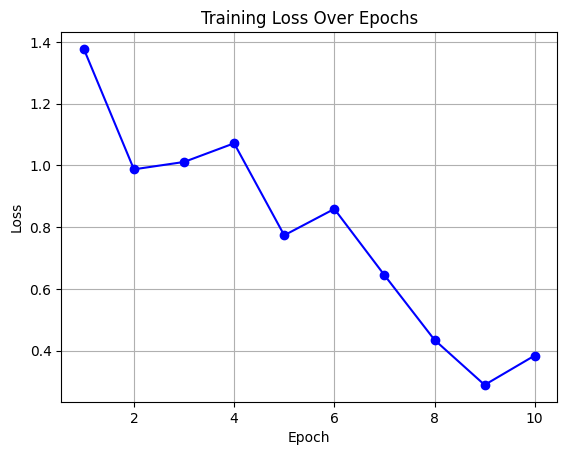

In [ ]:
import matplotlib.pyplot as plt

# Loss values
loss_values = [
    1.3774672746658325,
    0.9873966574668884,
    1.0112413167953491,
    1.0717753171920776,
    0.7736700773239136,
    0.8591105341911316,
    0.6446238160133362,
    0.4347948729991913,
    0.2889463007450104,
    0.38417425751686096
]

# Number of epochs
epochs = range(1, len(loss_values) + 1)

# Plotting the loss values
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='b')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# **Sample Test Predictions**

Image: /content/drive/MyDrive/Ai_proj/seg_test/sea/20167.jpg, Predicted Class: Sea


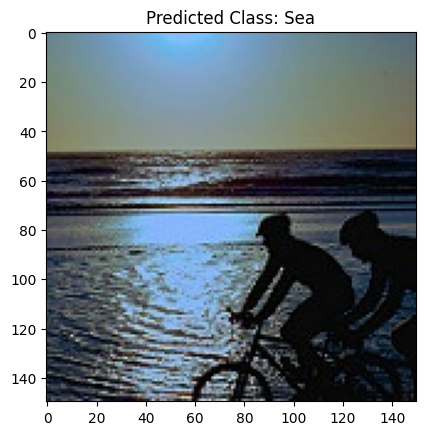

Image: /content/drive/MyDrive/Ai_proj/seg_test/mountain/20129.jpg, Predicted Class: Mountain


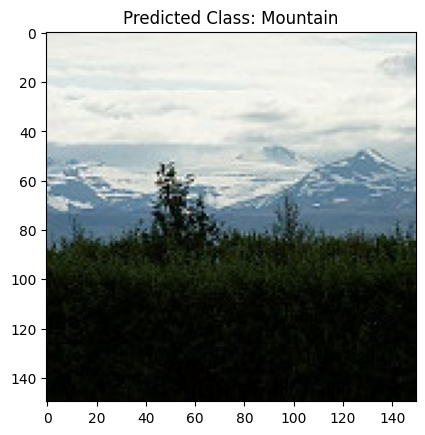

Image: /content/drive/MyDrive/Ai_proj/seg_test/glacier/20059.jpg, Predicted Class: Glacier


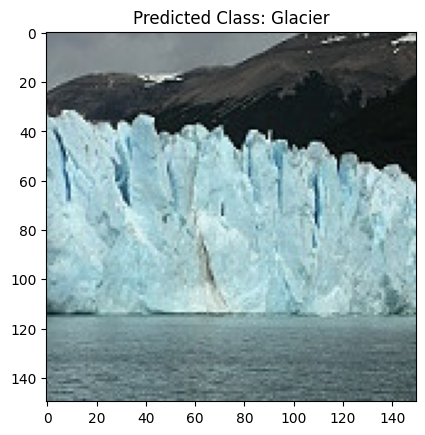

Image: /content/drive/MyDrive/Ai_proj/seg_test/buildings/20057.jpg, Predicted Class: Building


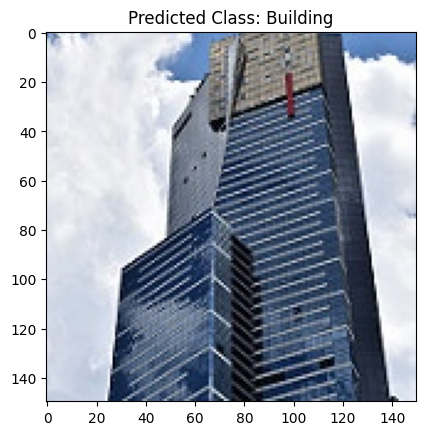

Image: /content/drive/MyDrive/Ai_proj/seg_test/sea/20124.jpg, Predicted Class: Sea


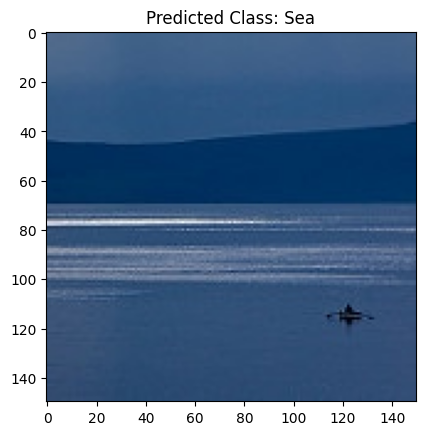

Image: /content/drive/MyDrive/Ai_proj/seg_test/forest/20089.jpg, Predicted Class: Forest


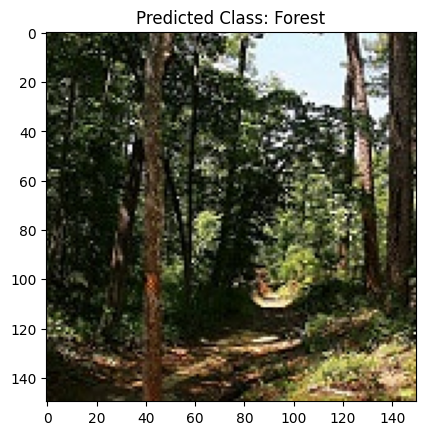

In [ ]:
import pickle
import torch
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt

# Define the transformation for input images
transform = ToTensor()

# Load the saved model using pickle
saved_model_path =  "/content/drive/MyDrive/Ai_proj/best_model.pkl"
with open(saved_model_path, 'rb') as model_file:
    loaded_model = pickle.load(model_file)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model = loaded_model.to(device)
loaded_model.eval()  # Set the model to evaluation mode

# Mapping of class indices to labels
class_labels = {
    0: "Building",
    1: "Forest",
    2: "Glacier",
    3: "Mountain",
    4: "Sea",
    5: "Street"
}

# Assuming you have three image paths for prediction
image_paths = ["/content/drive/MyDrive/Ai_proj/seg_test/sea/20167.jpg","/content/drive/MyDrive/Ai_proj/seg_test/mountain/20129.jpg","/content/drive/MyDrive/Ai_proj/seg_test/glacier/20059.jpg", "/content/drive/MyDrive/Ai_proj/seg_test/buildings/20057.jpg","/content/drive/MyDrive/Ai_proj/seg_test/sea/20124.jpg","/content/drive/MyDrive/Ai_proj/seg_test/forest/20089.jpg"]

# Make predictions for each image and display the image
for image_path in image_paths:
    # Load the image
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)  # Move input to the same device as the model

    # Make prediction
    with torch.no_grad():
        output = loaded_model(input_tensor)

    # Get predicted class (assuming it's a classification task)
    _, predicted_class = torch.max(output, 1)

    # Print the corresponding label based on the predicted class
    predicted_label = class_labels.get(predicted_class.item(), "Unknown")

    # Display the image along with the predicted label
    print(f"Image: {image_path}, Predicted Class: {class_labels[predicted_class.item()]}")
    plt.imshow(image)
    plt.title(f"Predicted Class: {predicted_label}")
    plt.show()
